In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import mean, stddev, col, log
from pyspark.sql.functions import to_date, dayofweek, to_timestamp, datediff
from pyspark.sql import types 
from pyspark.sql.functions import col, udf
from datetime import datetime
from pyspark.sql.types import DateType
from pyspark.sql.functions import year, month
from pyspark.sql.functions import dayofmonth, weekofyear
from pyspark.sql.functions import split, explode
from pyspark.sql.functions import coalesce, first, lit
from pyspark.ml.feature import Binarizer
from pyspark.ml.feature import Bucketizer
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.sql.functions import regexp_extract, col

In [3]:
from modules.pyspark import CPySpark
from pyspark.sql import Row, SQLContext

In [4]:
spark = CPySpark(session=True, sql=True)

In [5]:
spark = spark.session

In [6]:
df = spark.read.csv("./data/2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)

In [8]:
df.toPandas()

,No,MLSID,StreetNumberNumeric,streetaddress,STREETNAME,PostalCode,StateOrProvince,City,SalesClosePrice,LISTDATE,...,RoomArea7,RoomFloor7,RoomArea8,RoomFloor8,Bedrooms,SQFTBELOWGROUND,AssumableMortgage,AssociationFee,ASSESSMENTPENDING,AssessedValuation
0,1,RMLS,11511,11511 Stillwater Blvd N,Stillwater,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,...,None,None,None,None,3,0,None,0,Unknown,0.0
1,2,RMLS,11200,11200 31st St N,31st,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,...,10x11,Main,11x11,Lower,4,960,None,0,Unknown,0.0
2,3,RMLS,8583,8583 Stillwater Blvd N,Stillwater,55042,MN,LELM - Lake Elmo,225000,6/26/2017 0:00,...,None,None,None,None,2,0,Not Assumable,0,No,0.0
3,4,RMLS,9350,9350 31st St N,31st,55042,MN,LELM - Lake Elmo,265000,8/25/2017 0:00,...,None,None,None,None,2,348,None,0,Unknown,0.0
4,5,RMLS,2915,2915 Inwood Ave N,Inwood,55042,MN,LELM - Lake Elmo,249900,9/12/2017 0:00,...,14x13,Lower,None,None,3,1026,None,0,No,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,RMLS,4933,4933 Sunflower Dr,Sunflower,55129,MN,WB - Woodbury,799000,8/1/2017 0:00,...,12x14,Lower,None,None,3,1686,None,102,No,86.0
4996,4997,RMLS,10746,10746 Watersedge Ln,Watersedge,55129,MN,WB - Woodbury,805000,8/1/2017 0:00,...,14x14,Lower,13x11,Lower,5,2220,None,80,No,0.0
4997,4998,RMLS,10721,10721 Watersedge Ln,Watersedge,55129,MN,WB - Woodbury,865000,3/27/2017 0:00,...,13x12,Upper,15x13,Upper,4,1861,None,86,No,0.0
4998,4999,RMLS,4981,4981 Sunflower Pl,Sunflower,55129,MN,WB - Woodbury,1050216,5/24/2017 0:00,...,13.6x11,Upper,12x11,Upper,4,0,None,105,Unknown,0.0


In [14]:
df = df.withColumn('TSQFT', (df['SQFTBELOWGROUND'] + df['SQFTABOVEGROUND']))
df = df.withColumn('PRICEPERTSQFT', (df['LISTPRICE']/df['TSQFT']))
df = df.withColumn('DAYSONMARKET', datediff('OFFMARKETDATE', 'LISTDATE'))

df.toPandas()

,No,MLSID,StreetNumberNumeric,streetaddress,STREETNAME,PostalCode,StateOrProvince,City,SalesClosePrice,LISTDATE,...,RoomArea8,RoomFloor8,Bedrooms,SQFTBELOWGROUND,AssumableMortgage,AssociationFee,ASSESSMENTPENDING,AssessedValuation,TSQFT,PRICEPERTSQFT
0,1,RMLS,11511,11511 Stillwater Blvd N,Stillwater,55042,MN,LELM - Lake Elmo,143000,7/15/2017 0:00,...,None,None,3,0,None,0,Unknown,0.0,980,142.755102
1,2,RMLS,11200,11200 31st St N,31st,55042,MN,LELM - Lake Elmo,190000,10/9/2017 0:00,...,11x11,Lower,4,960,None,0,Unknown,0.0,2228,94.254937
2,3,RMLS,8583,8583 Stillwater Blvd N,Stillwater,55042,MN,LELM - Lake Elmo,225000,6/26/2017 0:00,...,None,None,2,0,Not Assumable,0,No,0.0,1102,204.174229
3,4,RMLS,9350,9350 31st St N,31st,55042,MN,LELM - Lake Elmo,265000,8/25/2017 0:00,...,None,None,2,348,None,0,Unknown,0.0,1632,140.931373
4,5,RMLS,2915,2915 Inwood Ave N,Inwood,55042,MN,LELM - Lake Elmo,249900,9/12/2017 0:00,...,None,None,3,1026,None,0,No,0.0,2052,116.910331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,RMLS,4933,4933 Sunflower Dr,Sunflower,55129,MN,WB - Woodbury,799000,8/1/2017 0:00,...,None,None,3,1686,None,102,No,86.0,3638,222.045080
4996,4997,RMLS,10746,10746 Watersedge Ln,Watersedge,55129,MN,WB - Woodbury,805000,8/1/2017 0:00,...,13x11,Lower,5,2220,None,80,No,0.0,5923,143.508357
4997,4998,RMLS,10721,10721 Watersedge Ln,Watersedge,55129,MN,WB - Woodbury,865000,3/27/2017 0:00,...,15x13,Upper,4,1861,None,86,No,0.0,5946,151.362092
4998,4999,RMLS,4981,4981 Sunflower Pl,Sunflower,55129,MN,WB - Woodbury,1050216,5/24/2017 0:00,...,12x11,Upper,4,0,None,105,Unknown,0.0,4321,243.049294


In [15]:
acres_to_sqfeet = 43560
df = df.withColumn('LOT_SIZE_SQFT', df['ACRES'] * acres_to_sqfeet)

df = df.withColumn('YARD_SIZE', df['LOT_SIZE_SQFT'] - df['FOUNDATIONSIZE'])


In [18]:
df.corr('ACRES', 'SalesClosePrice')

0.22060612588935327

In [17]:
df.corr('FOUNDATIONSIZE', 'SalesClosePrice')

0.6152231695664401

In [19]:
df.corr('YARD_SIZE', 'SalesClosePrice')

0.20714585430854263

convert to date type

In [20]:
func = udf(lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M'), DateType())
df = df.withColumn('LISTDATE_new', func(col('LISTDATE')))

df = df.withColumn('List_Day_of_Week', dayofweek('LISTDATE_new'))
sample_df = df.sample(False, 0.5, 42).toPandas()

In [21]:
sample_df

,No,MLSID,StreetNumberNumeric,streetaddress,STREETNAME,PostalCode,StateOrProvince,City,SalesClosePrice,LISTDATE,...,AssumableMortgage,AssociationFee,ASSESSMENTPENDING,AssessedValuation,TSQFT,PRICEPERTSQFT,LOT_SIZE_SQFT,YARD_SIZE,LISTDATE_new,List_Day_of_Week
0,4,RMLS,9350,9350 31st St N,31st,55042,MN,LELM - Lake Elmo,265000,8/25/2017 0:00,...,None,0,Unknown,0.0,1632,140.931373,40946.40,39987.40,2017-08-25,6
1,8,RMLS,9934,9934 5th Street Ln N,5th Street,55042,MN,LELM - Lake Elmo,245000,11/5/2017 0:00,...,None,200,No,0.0,1733,147.137911,2178.00,1090.00,2017-11-05,1
2,11,RMLS,9902,9902 5th Street Ln N,5th Street,55042,MN,LELM - Lake Elmo,254500,5/19/2017 0:00,...,None,200,No,0.0,1733,150.023081,2178.00,1090.00,2017-05-19,6
3,13,RMLS,9894,9894 5th Street Ln N,5th Street,55042,MN,LELM - Lake Elmo,257500,3/12/2017 0:00,...,None,190,No,0.0,1733,150.023081,2178.00,1090.00,2017-03-12,1
4,17,RMLS,9898,9898 5th St Ln N,5th St,55042,MN,LELM - Lake Elmo,274990,9/10/2017 0:00,...,None,200,No,0.0,1763,155.978446,2178.00,1090.00,2017-09-10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2547,4992,RMLS,3507,3507 Crestmoor Pt,Crestmoor,55125,MN,WB - Woodbury,770000,5/3/2017 0:00,...,None,440,No,0.0,3489,222.126684,35719.20,33170.20,2017-05-03,4
2548,4994,RMLS,10869,10869 Bentwater Ln,Bentwater,55129,MN,WB - Woodbury,795000,7/21/2017 0:00,...,None,80,No,0.0,6037,132.350505,15681.60,13770.60,2017-07-21,6
2549,4998,RMLS,10721,10721 Watersedge Ln,Watersedge,55129,MN,WB - Woodbury,865000,3/27/2017 0:00,...,None,86,No,0.0,5946,151.362092,9147.60,7051.60,2017-03-27,2
2550,4999,RMLS,4981,4981 Sunflower Pl,Sunflower,55129,MN,WB - Woodbury,1050216,5/24/2017 0:00,...,None,105,Unknown,0.0,4321,243.049294,0.00,-1919.00,2017-05-24,4


In [22]:
sample_df[['LISTDATE', 'LISTDATE_new', 'List_Day_of_Week']].head()

,LISTDATE,LISTDATE_new,List_Day_of_Week
0,8/25/2017 0:00,2017-08-25,6
1,11/5/2017 0:00,2017-11-05,1
2,5/19/2017 0:00,2017-05-19,6
3,3/12/2017 0:00,2017-03-12,1
4,9/10/2017 0:00,2017-09-10,1


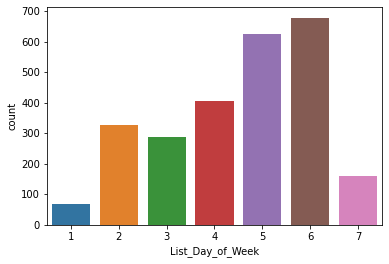

In [23]:
ax = sns.countplot(x='List_Day_of_Week', data=sample_df)
plt.show()

In [25]:
df = df.withColumn('LIST_YEAR', year('LISTDATE_new'))
df = df.withColumn('LIST_MONTH', month('LISTDATE_new'))
df = df.withColumn('LIST_DAYOFMONTH', dayofmonth('LISTDATE_new'))
df = df.withColumn('LIST_WEEKOFYEAR', weekofyear('LISTDATE_new'))

df[['LISTDATE_new', 'LIST_YEAR', 'LIST_MONTH', 'LIST_DAYOFMONTH', 'LIST_WEEKOFYEAR']].show(5)

+------------+---------+----------+---------------+---------------+
|LISTDATE_new|LIST_YEAR|LIST_MONTH|LIST_DAYOFMONTH|LIST_WEEKOFYEAR|
+------------+---------+----------+---------------+---------------+
|  2017-07-15|     2017|         7|             15|             28|
|  2017-10-09|     2017|        10|              9|             41|
|  2017-06-26|     2017|         6|             26|             26|
|  2017-08-25|     2017|         8|             25|             34|
|  2017-09-12|     2017|         9|             12|             37|
+------------+---------+----------+---------------+---------------+
only showing top 5 rows



In [26]:
from pyspark.sql.functions import when

In [27]:
has_attached_garage = df['GARAGEDESCRIPTION'].like('%Attached Garage%')
has_detached_garage = df['GARAGEDESCRIPTION'].like('%Detached Garage%')


In [30]:
df = df.withColumn('has_attached_garage', (when(has_attached_garage, 1)
                                            .when(has_detached_garage, 0)
                                            .otherwise(None)))

In [31]:
df[['GARAGEDESCRIPTION', 'has_attached_garage']].show(truncate=50, n=3)

+--------------------------------------------------+-------------------+
|                                 GARAGEDESCRIPTION|has_attached_garage|
+--------------------------------------------------+-------------------+
|                                   Attached Garage|                  1|
|Attached Garage, Driveway - Asphalt, Garage Doo...|                  1|
|                                   Attached Garage|                  1|
+--------------------------------------------------+-------------------+
only showing top 3 rows



In [32]:
split_col = split(df['ROOF'], ',')
df = df.withColumn('Roof_Material', split_col.getItem(0))
df[['ROOF', 'Roof_Material']].show(5, truncate=100)

+----------------------------------------------+----------------+
|                                          ROOF|   Roof_Material|
+----------------------------------------------+----------------+
|                                          null|            null|
|Asphalt Shingles, Pitched, Age 8 Years or Less|Asphalt Shingles|
|                                          null|            null|
|Asphalt Shingles, Pitched, Age 8 Years or Less|Asphalt Shingles|
|            Asphalt Shingles, Age Over 8 Years|Asphalt Shingles|
+----------------------------------------------+----------------+
only showing top 5 rows



In [33]:
df = df.withColumn('roof_list', split(df['ROOF'], ','))
df[['No', 'roof_list']].show(4, truncate=50)

+---+--------------------------------------------------+
| No|                                         roof_list|
+---+--------------------------------------------------+
|  1|                                              null|
|  2|[Asphalt Shingles,  Pitched,  Age 8 Years or Less]|
|  3|                                              null|
|  4|[Asphalt Shingles,  Pitched,  Age 8 Years or Less]|
+---+--------------------------------------------------+
only showing top 4 rows



In [34]:
roof_df = df.withColumn('ex_roof_list', explode(df['roof_list']))
roof_df[['No', 'ex_roof_list']].show(5, truncate=50)

+---+--------------------+
| No|        ex_roof_list|
+---+--------------------+
|  2|    Asphalt Shingles|
|  2|             Pitched|
|  2| Age 8 Years or Less|
|  4|    Asphalt Shingles|
|  4|             Pitched|
+---+--------------------+
only showing top 5 rows



In [35]:
roof_df = roof_df.withColumn('constant_val', lit(1))
roof_piv_df = roof_df.groupBy('NO').pivot('ex_roof_list').agg(coalesce(first('constant_val')))

In [37]:
roof_piv_df.toPandas()

,NO,Age 8 Years or Less,Age Over 8 Years,Flat,Metal,Other,Pitched,Rubber,Shakes,Slate,...,Metal,Other,Pitched,Rubber,Shakes,Slate,Tar/Gravel,Tile,Unspecified Shingle,Wood Shingles
0,4519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2659,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4230,4585,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4231,1476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4232,3825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4233,3668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
roof_piv_df.toPandas().shape

(4235, 28)

In [41]:
roof_piv_df.orderBy('No').toPandas()

,NO,Age 8 Years or Less,Age Over 8 Years,Flat,Metal,Other,Pitched,Rubber,Shakes,Slate,...,Metal,Other,Pitched,Rubber,Shakes,Slate,Tar/Gravel,Tile,Unspecified Shingle,Wood Shingles
0,2,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4230,4994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4231,4995,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4232,4997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4233,4998,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
roof_piv_df.show()

+----+--------------------+-----------------+-----+------+------+--------+-------+-------+------+-----------+-----+--------------------+--------------+-------------------+----------------+----------------+----+-----+-----+-------+------+------+-----+----------+----+-------------------+-------------+
|  NO| Age 8 Years or Less| Age Over 8 Years| Flat| Metal| Other| Pitched| Rubber| Shakes| Slate| Tar/Gravel| Tile| Unspecified Shingle| Wood Shingles|Age 8 Years or Less|Age Over 8 Years|Asphalt Shingles|Flat|Metal|Other|Pitched|Rubber|Shakes|Slate|Tar/Gravel|Tile|Unspecified Shingle|Wood Shingles|
+----+--------------------+-----------------+-----+------+------+--------+-------+-------+------+-----------+-----+--------------------+--------------+-------------------+----------------+----------------+----+-----+-----+-------+------+------+-----+----------+----+-------------------+-------------+
|4519|                null|             null| null|  null|  null|    null|   null|   null|  null|

In [44]:
joined_data = df.join(roof_piv_df, on='No', how='left')
zfill_cols = roof_piv_df.columns
zfill_df = joined_data.fillna(0, subset=zfill_cols)

In [46]:
zfill_df.show(3)

+---+-----+-------------------+--------------------+----------+----------+---------------+----------------+---------------+--------------+---------+---------------+-----------------+------------+--------------+-----+---------+-----------------+--------------------+------------+---------------+----------+---------+--------------------+--------------------+----------+------------------+---------------+----+--------------------+---------------+-----+----------+---------+------------------+-------+----------+----------+---------+------------------+--------------------+-----+------------------+--------------------+----------------+--------------+---------+------------+----------+----------+---------+---------------------+--------------------+---------+---------+-----------+-----------------+-----+----------+--------------------+---------+----------+---------+----------+---------+----------+---------+----------+--------+---------------+-----------------+--------------+-----------------+-----